In [19]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
from networks.cnn import CNN_test, CNN_pool, CNN_var
from networks.tests import VisionTransformer
import matplotlib.pyplot as plt
import pyreadr
from scipy.integrate import quad
import scipy as sc

In [8]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [9]:
def corr_func(h, method, r, s):
    if method=="powexp":
        res = np.exp(-np.power((h/r),s))
    elif method=="brown":
        res = np.power((h/r),s)
    return res    

In [10]:
def extremal_coefficient(h, method, r, s):
    if method=="powexp":
        res = 1+np.sqrt(1-(np.exp(-np.power(np.abs(h)/r,s))/2))
    elif method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(np.power(np.abs(h)/r,s))/2,loc = 0, scale = 1)    
    return res    

In [11]:
def error_function(h, model, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    if method == "corr":
        error = np.power(corr_func(h, model, r_true, s_true)- corr_func(h, model, r_est, s_est),2)
    elif method =="ext":
        error = np.power(extremal_coefficient(h, model, r_true, s_true)- extremal_coefficient(h, model, r_est, s_est),2)
    return error

In [12]:
def get_imse(data, model, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (model, method, pred, params))
    return error

In [13]:
def get_metrics(pred, param, model):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse_corr = np.mean(np.array([get_imse(x, model, "corr") for x in np.append(pred, param, axis = 1)]))
    imse_ext = np.mean(np.array([get_imse(x, model, "ext") for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"Corr - IMSE: {np.round(imse_corr,2)}")    
    print(f"Ext - IMSE: {np.round(imse_ext,2)}")
    
    #print(f"Bias: {np.round(bias,2)}")

# Results for 3D Model

## PL

In [31]:
n_comb = 25
n_each = 20

In [51]:
exp = "exp_4_1"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
_, idx = np.unique(brown_params, axis = 0, return_index = True)
brown_params = np.repeat(brown_params[np.sort(idx)], n_each, axis = 0)
schlather_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
_, idx = np.unique(schlather_params, axis = 0, return_index = True)
schlather_params = np.repeat(schlather_params[np.sort(idx)], n_each, axis = 0)
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt.RData")["results"].to_numpy()[:,1:]

In [61]:
# Brown metrics
get_metrics(brown_res,brown_params, "brown")

RMSE: [1.75 0.47]
MAE: [1.63 0.38]
Corr - IMSE: 216655495.81
Ext - IMSE: 0.56


In [62]:
get_metrics(schlather_res,schlather_params, "powexp")

RMSE: [1.41 0.74]
MAE: [1.2 0.6]
Corr - IMSE: 1.03
Ext - IMSE: 0.07


## Brown

In [63]:
# Dataloader
exp = "exp_4_1"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [64]:
#Load model
net = CNN_test(channels=5)
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [65]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [66]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [67]:
# Brown metrics
get_metrics(pred_tf,param_tf, "brown")

RMSE: [0.44 0.19]
MAE: [0.34 0.15]
Corr - IMSE: 20358.8
Ext - IMSE: 0.29


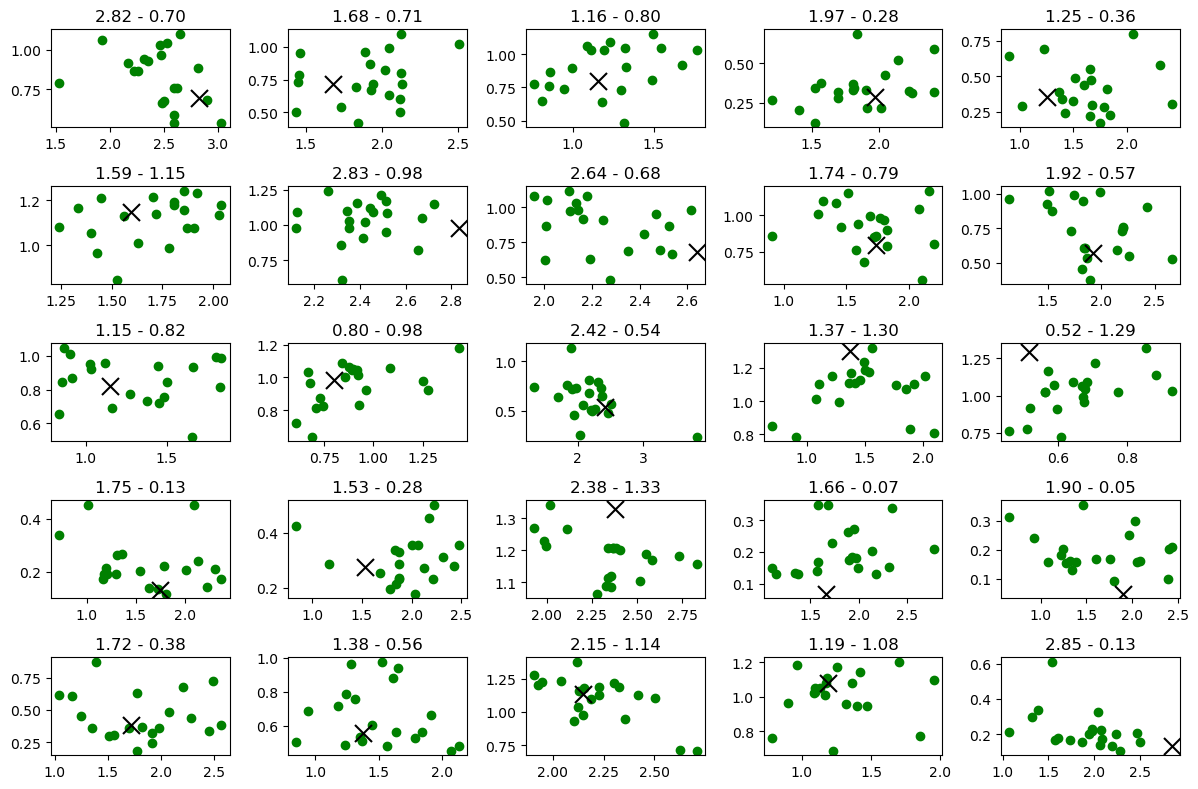

In [68]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

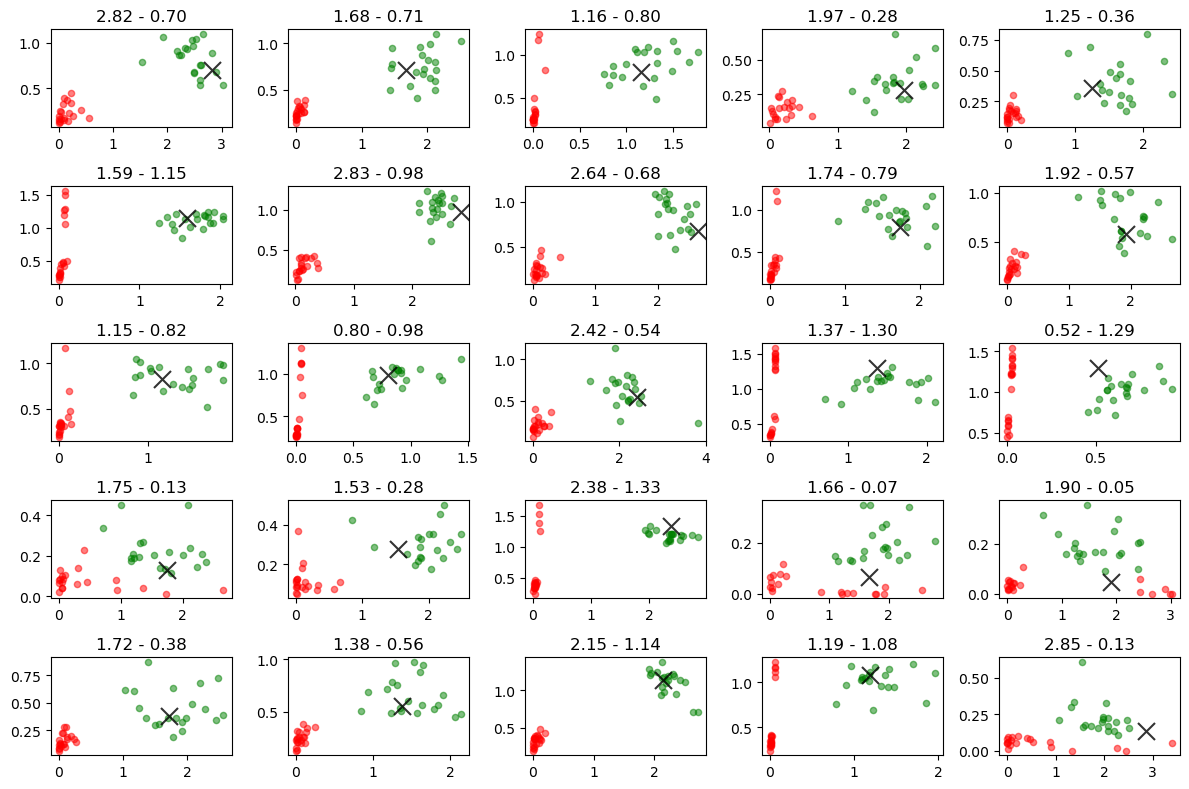

In [70]:
# With Likelihood fixed range
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

## Schlather

In [71]:
# Dataloader
exp = "exp_4_1"
path = f"../data/{exp}/data/"
model = "powexp"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [72]:
#Load model
net = CNN_test(channels=5)
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [73]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [74]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [75]:
# Schlather metrics
get_metrics(pred_tf,param_tf, model)

RMSE: [0.59 0.33]
MAE: [0.48 0.28]
Corr - IMSE: 0.52
Ext - IMSE: 0.04


In [76]:
# Plot results
n_comb = 25
n_each = 20

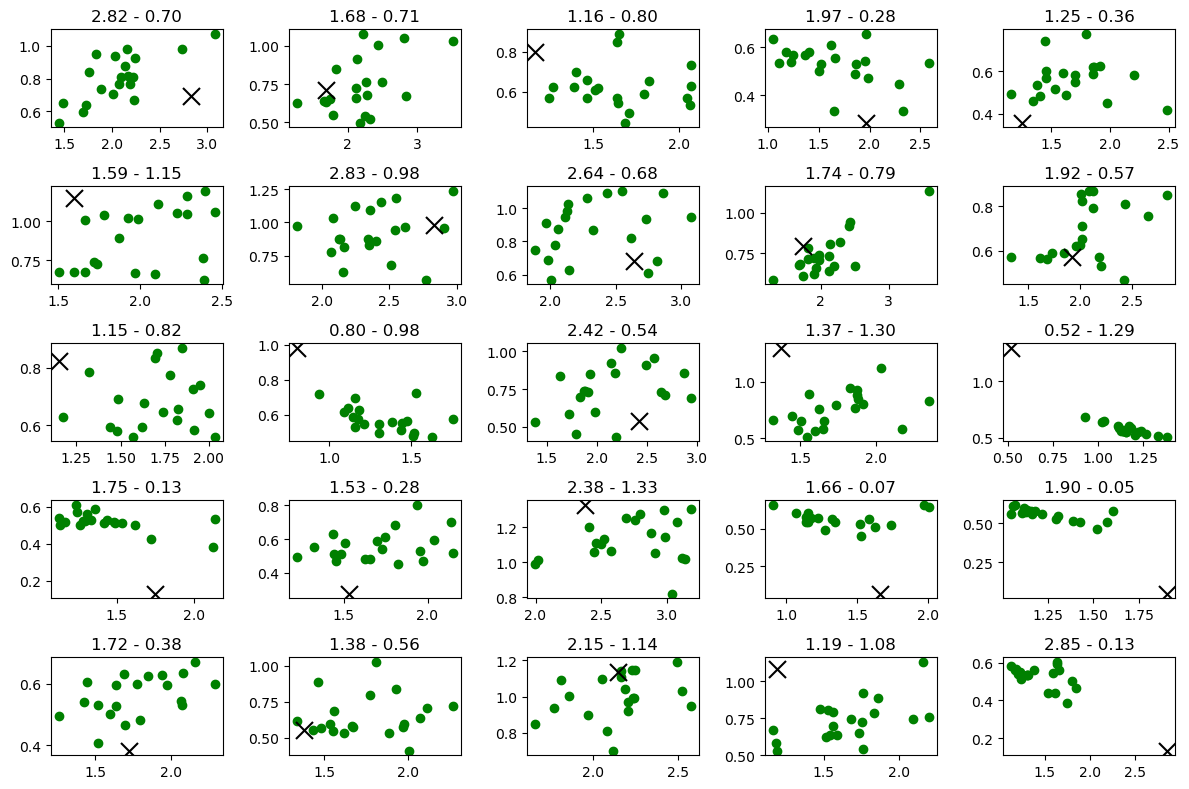

In [77]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

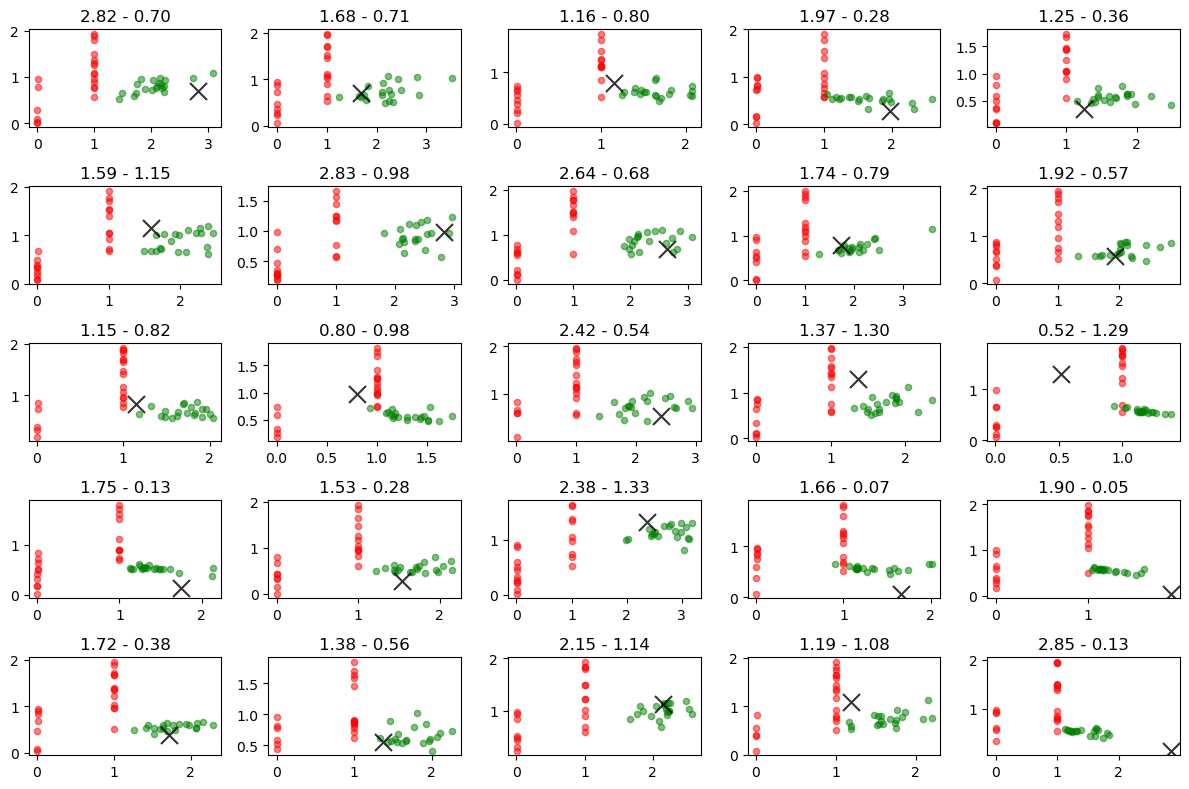

In [78]:
# With Likelihood fixed range
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")